# Homework 7
Eric Gagliano (egagli)

## Problem 1: ENSO Phases

### A. Following Lab 7-1 and Lab 7-2, use the time series of the phase of the El Niño Southern Oscillation (ENSO) from 1900-2021 to create a lag-1 Markov model of the ENSO phase. where the observed Phases of ENSO are as follows:
1. warm (El Niño)
2. neutral (ENSO neutral)
3. cool (La Niña)

In [1]:
# imports
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.io as sio 
%matplotlib inline

In [2]:
# read in ENSO data into a dataframe
enso_df = pd.read_csv('ENSO_to2021.csv', comment='#')
enso_df
data = enso_df['ENSO Phase']

In [3]:
# count the transitions from each state to the next
enso_phase_ct = sparse.csr_matrix((np.ones_like(data[:-1]), (data[:-1], data[1:])), dtype=float)
# convert transition counts to matrix form
enso_phase_dense = enso_phase_ct.todense()
# normalize transition matrix to get probs
enso_phase_probs = enso_phase_dense / enso_phase_dense.sum(axis=1)
print(enso_phase_probs)

[[       nan        nan        nan        nan]
 [0.         0.275      0.3        0.425     ]
 [0.         0.32432432 0.40540541 0.27027027]
 [0.         0.36363636 0.22727273 0.40909091]]


<ipython-input-3-5fdabc083fb7>:6: RuntimeWarning: invalid value encountered in true_divide
  enso_phase_probs = enso_phase_dense / enso_phase_dense.sum(axis=1)


In [4]:
# Compute cumulative sums along the rows, make sure these sum to 1. (We will use this cdf matrix below in a simulation of ENSO phases)
enso_phase_cdf = np.cumsum(enso_phase_probs,1)
print(enso_phase_cdf)

[[       nan        nan        nan        nan]
 [0.         0.275      0.575      1.        ]
 [0.         0.32432432 0.72972973 1.        ]
 [0.         0.36363636 0.59090909 1.        ]]


### B) Using this Markov model and a random number generator, simulate 5,000 years of ENSO data.

In [5]:
# pick the number of years we want to simulate (5000)
n_years = 5000
# use a uniform random number for 5000 years
q = np.random.uniform(0,1,n_years)
# start off in state 2, neutral
initialstate = 2
# initialize an array of the proper size, with the initial state
Nrand = np.zeros_like(q)
Nrand[0] = initialstate

# Now, just like we did when we created monte carlo simulations from empirical CDFs,
# we use our uniform random numbers to look up the next state in the transition matrix
for i in range(1,n_years):
    if q[i] <= enso_phase_cdf[int(Nrand[i-1]),1]: #probability of transitioning from state i to 1
        Nrand[i] = 1
    elif q[i] <= enso_phase_cdf[int(Nrand[i-1]),2]: #transition from state i to 2
        Nrand[i] = 2
    elif q[i] <= enso_phase_cdf[int(Nrand[i-1]),3]: #transition from state i to 3
        Nrand[i] = 3

### C) Using this randomly generated data, answer the following questions.

- According to the model, what is the probability that three warm ENSO years would occur in a row?

In [6]:
# calculate model[1,1]^3 to get theoretical value of probability of 3 warm ENSO years in a row
print(f'According to the model, the probability of three warm ENSO years in a row is p = {np.round(((enso_phase_probs[2,1]+enso_phase_probs[3,1])/2)*enso_phase_probs[1,1]**2,3)} ({np.round(100*((enso_phase_probs[2,1]+enso_phase_probs[3,1])/2)*enso_phase_probs[1,1]**2,3)}%)')

According to the model, the probability of three warm ENSO years in a row is p = 0.026 (2.601%)


In [7]:
# for comparison, lets check what the simulation comes up with
# stack our data 3 times, shifting it to the right by 1 each time
Test_warm_3 = [Nrand[0:-2], Nrand[1:-1], Nrand[2:]] 
Test_warm_3 = np.stack(Test_warm_3, axis=1)

# count number of 3 consecutive warm days
G2 = np.where((np.max(Test_warm_3, axis=1) == 1) & (np.min(Test_warm_3, axis=1) == 1))

# calculate proportion of 3 consecutive warm days / 3 consecutive days in the simulation
frequency_of_3_warm = G2[0].size / Test_warm_3.shape[0]

print(f'Simulated frequency of three warm ENSO years in a row = {np.round(100*frequency_of_3_warm,3)}%')

Simulated frequency of three warm ENSO years in a row = 2.801%


As seen above, our model probability and simulated probability are almost identical!

- What is the large-sample probability that three cool ENSO years would happen in a row? (Try refreshing the numbers several times to increase the sample size if the condition never happens.)

In [8]:
# stack our data 3 times, shifting it to the right by 1 each time
Test_cool_3 = [Nrand[0:-2], Nrand[1:-1], Nrand[2:]] 
Test_cool_3 = np.stack(Test_cool_3, axis=1)

# count number of 3 consecutive cool days
G2 = np.where((np.max(Test_cool_3, axis=1) == 3) & (np.min(Test_cool_3, axis=1) == 3))

# calculate proportion of 3 consecutive cool days / 3 consecutive days in the simulation
frequency_of_3_cool = G2[0].size / Test_cool_3.shape[0]

print(f'Simulated frequency of three cool ENSO years in a row = {np.round(100*frequency_of_3_cool,3)}%')

Simulated frequency of three cool ENSO years in a row = 6.403%


## Probelm 2: Rating Curves and Application of Bayes Theorem with MCMC

Following the class discussion and Lab 7-3, explore how the rating curve and the 95% confidence intervals for the Lyell Fork streamflow site change depending on the method you use to determine the rating curve. Using the code in Lab 7-3, create plots and discuss the differences in the results from these three methods.

### A. Least squares linear regression fitting (with transformed variables) using h0 = 28 cm
- Make 95% confidence intervals around this regression fit
- Then, assume that we don't know exactly what h0 is. Try additional linear regressions using different values of h0 = 10, 20, 30, 40, and 50 cm (you do not need to calculate 95% confidence intervals for these additional fits)
- Qualitatively, is the range between these 5 additional lines with different h0 values larger or smaller than the range between the 95% confidence lines from the original fitted line (the one with h0 = 28 cm)?

In [9]:
# import data and create dataframe
data = sio.loadmat('Lyell_h_Q_sorted.mat')
df = pd.DataFrame(np.hstack((data['date_of_obs'], data['h1'], data['Qobs1'])),
                  columns=['date_of_obs','h1', 'Qobs1'])
df['date_of_obs'] = [pd.to_datetime(dt[0], format='%m/%d/%y %H:%M') for dt in df['date_of_obs']]

In [10]:
#h0 = 28 #cm
h0_list = np.array([.28,.10,.20,.30,.40,.50])

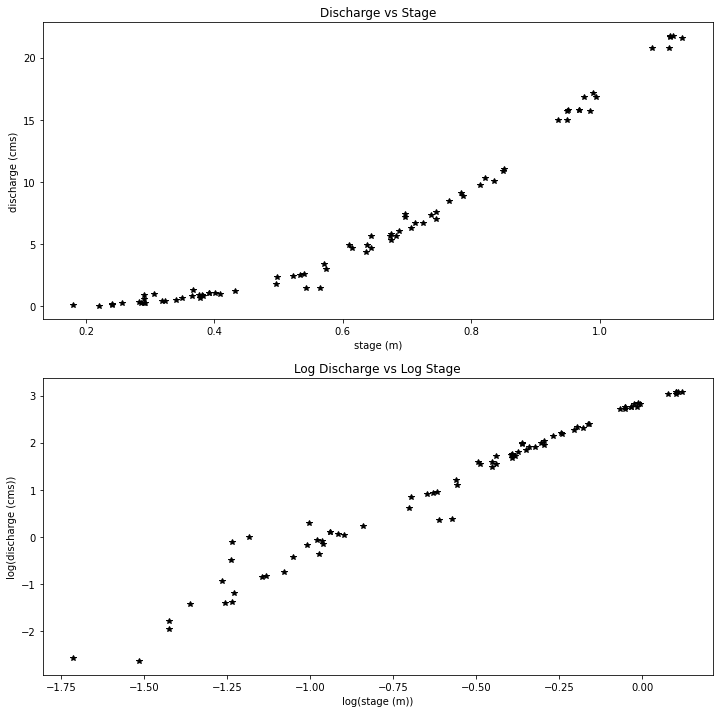

In [11]:
# First, let's plot all of the data we just read in.
f,ax = plt.subplots(2,1,figsize=(12,12))

ax[0].set_xlabel('stage (m)')
ax[0].set_ylabel('discharge (cms)')
ax[0].plot(df.h1,df.Qobs1,'k*')
ax[0].set_title('Discharge vs Stage')

loght=np.log(df.h1.astype('float'))
logQ=np.log(df.Qobs1.astype('float'))


ax[1].set_title('Log Discharge vs Log Stage')
ax[1].set_xlabel('log(stage (m))')
ax[1].set_ylabel('log(discharge (cms))')
ax[1].plot(loght,logQ,'k*')

In [12]:
h11 = 0.59
Qobs_now = df.Qobs1[df.h1 > h11]
h_now = df.h1[df.h1 > h11]

In [13]:
#And plot the log transform of both variables
loght=np.log(h_now.astype('float'))
logQ=np.log(Qobs_now.astype('float'))

In [14]:
x = np.zeros((len(loght),len(h0_list)))

B1 = np.zeros(len(h0_list))
B0 = np.zeros(len(h0_list))

for i,b in enumerate(h0_list):
    loghb = np.log(h_now.astype('float')-b)
    #x =  np.append(x, loghb, 1)
    #x = np.concatenate((x, loghb), 1)
    x[:,i] = loghb

    y=logQ
    n = len(loght)

    B1[i] = ( n*np.sum(x[:,i]*y) - np.sum(x[:,i])*np.sum(y) ) / ( n*np.sum(x[:,i]**2) - np.sum(x[:,i])**2 ) # B1 parameter, slope
    B0[i] = np.mean(y) - B1[i]*np.mean(x[:,i]) # B0 parameter, y-intercept

    print(f'For b = {b}, B0 : {np.round(B0[i],4)}')
    print(f'For b = {b}, B1 : {np.round(B1[i],4)}')

For b = 0.28, B0 : 3.4077
For b = 0.28, B1 : 1.7662
For b = 0.1, B0 : 3.0771
For b = 0.1, B1 : 2.3636
For b = 0.2, B0 : 3.2819
For b = 0.2, B1 : 2.0337
For b = 0.3, B0 : 3.433
For b = 0.3, B1 : 1.6986
For b = 0.4, B0 : 3.5154
For b = 0.4, B1 : 1.3537
For b = 0.5, B0 : 3.496
For b = 0.5, B1 : 0.9861


In [15]:
# Now, how do we find 95% confidence intervals?  We do this for our estimates of logQ
# Again, borrowing from Lab 4.3
y_predicted = B0[0] + B1[0]*x[:,0]
residuals = (y - y_predicted)
# sum of squared errors
sse = np.sum(residuals**2)
# standard error of regression
s = np.sqrt(sse/(n-2))

# create an array of x values
p_x = np.linspace(x[:,0].min(),x[:,0].max(),100)

# using our model parameters to predict y values
p_y = B0[0] + B1[0]*p_x

# calculate the standard error of the predictions
sigma_ep = np.sqrt( s**2 * (1 + 1/n + ( ( n*(p_x-x[:,0].mean())**2 ) / ( n*np.sum(x[:,0]**2) - np.sum(x[:,0])**2 ) ) ) )

# our chosen alpha
alpha = 0.05

# compute our degrees of freedom with the length of the predicted dataset
n = len(p_x)
dof = n - 2

# get the t-value for our alpha and degrees of freedom
t = stats.t.ppf(1-alpha/2, dof)

# compute the upper and lower limits at each of the p_x values
p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep

Text(0.5, 1.0, 'Discharge vs Stage for h0=0.28')

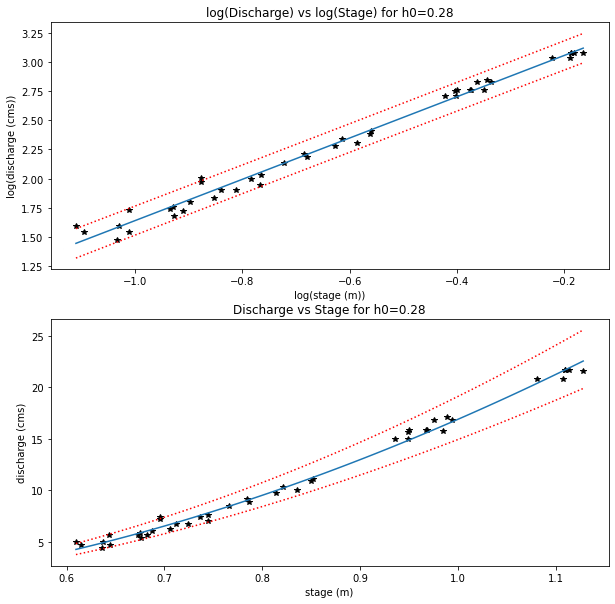

In [16]:
# First let's make a plot in the log-transformed space
f,ax=plt.subplots(2,1,figsize=(10,10))

ax[0].set_xlabel('log(stage (m))')
ax[0].set_ylabel('log(discharge (cms))')
ax[0].plot(x[:,0],logQ,'k*',label='data')
ax[0].plot(p_x,p_y,label='h0=0.28')
ax[0].plot(p_x,p_y_lower,':r',label='h0=0.28 95% Confidence')
ax[0].plot(p_x,p_y_upper,':r')
ax[0].set_title('log(Discharge) vs log(Stage) for h0=0.28')
# Now we transform each piece back into the original form
Q_predict=np.exp(p_y)
Q_predict_upper=np.exp(p_y_upper)
Q_predict_lower=np.exp(p_y_lower)
x_topredict=np.exp(p_x) + h0_list[0]
# Plot the original data and then the prediction lines

ax[1].set_xlabel('stage (m)')
ax[1].set_ylabel('discharge (cms)')
ax[1].plot(h_now,Qobs_now,'k*',label='data')
ax[1].plot(x_topredict,Q_predict,label='h0=0.28')
ax[1].plot(x_topredict,Q_predict_lower,':r',label='h0=0.28 95% Confidence')
ax[1].plot(x_topredict,Q_predict_upper,':r')
ax[1].set_title('Discharge vs Stage for h0=0.28')

(0.6, 1.3)

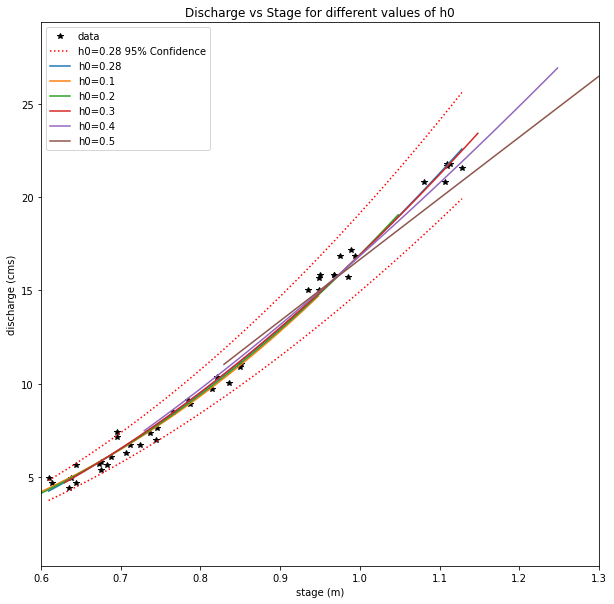

In [17]:
f,ax=plt.subplots(figsize=(10,10))
ax.set_xlabel('stage (m)')
ax.set_ylabel('discharge (cms)')
ax.plot(h_now,Qobs_now,'k*',label='data')
ax.plot(x_topredict,Q_predict_lower,':r',label='h0=0.28 95% Confidence')
ax.plot(x_topredict,Q_predict_upper,':r')
for i in range(len(h0_list)):
    p_y = B0[i] + B1[i]*p_x
    prediction = np.exp(p_y)
    x_topredict=np.exp(p_x) + h0_list[i]
    ax.plot(x_topredict,prediction,label=f'h0={h0_list[i]}')
ax.legend()
ax.set_title('Discharge vs Stage for different values of h0')
ax.set_xlim([0.6,1.3])

Qualitatively, all of the h0 guesses fall within the 95% confidence interval of h0=0.28 in the interval we evaulated on. They width between the curves is smaller than the 95% confidence interval. However, as h0 increases it becomes easier to predict higher flows. At these higher values though, we begin to diverge from the h0=0.28 95% confidence interval. This shows us the importance of constraining our h0 value.

### B. Direct monte carlo parameter estimation

In [18]:
nx=10
# for c, we know that at higher flows (which we've restricted our sample to), c = 5/3 or 1.67
# We allow c to vary slightly around this theoretical value
c = np.linspace(1.67-0.05,1.67+0.05,nx)
# b is an empirical constant of where the upper level equation intersects 0 
# b only represents the true 0 level for the lower portion of the rating curve equation
# here, we guess a range of values based on visual inspection of our data
b = np.linspace(0.15,0.45,nx)
# a can be estimated as a function of channel slope and roughness (see paper by LeCoz et al.)
# for now, we will just guess a range of values that seem reasonable by visual inspection
a = np.linspace(5,50,nx)

In [19]:
# Set up the arrays we'll populate with data below
Qest = np.ones((10,10,10,h_now.size)) # for estimating Q with each parameter set
Qfit = np.ones((10,10,10)) # for RMSE values

In [20]:
# Iterate through all combinations of a, b, and c parameters
# Then calculate Qest, and Qfit (RMSE)

for ic in range(nx):
    for ib in range(nx):
        for ia in range(nx):
            Qest[ia,ib,ic,:] = a[ia] * (h_now-b[ib])**c[ic]
            temp = np.reshape(Qest[ia,ib,ic,:],Qobs_now.size)
            Qfit[ia,ib,ic]=np.sqrt( np.mean( (temp-Qobs_now)**2 ) ) # calculate RMSE for this parameter set


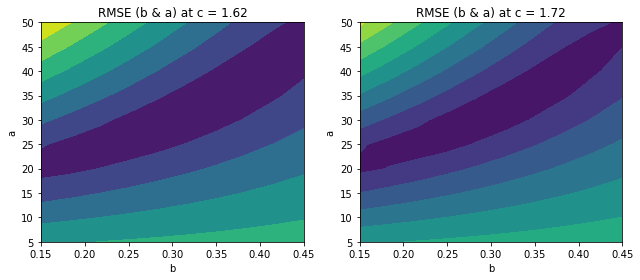

In [21]:
f, ax = plt.subplots(1,2,figsize=(9,4))
ic = 0 # select the first value of c
Qfit_temp = np.reshape(Qfit[:,:,ic],[10,10]);
ax[0].contourf(b,a,Qfit_temp)
ax[0].set_xlabel('b')
ax[0].set_ylabel('a')
ax[0].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

ic = -1 # the last value of c (using the index "-1" to represent the last value in the array)
Qfit_temp2 = np.reshape(Qfit[:,:,ic],[10,10]);
ax[1].contourf(b,a,Qfit_temp2)
ax[1].set_xlabel('b')
ax[1].set_ylabel('a')
ax[1].set_title('RMSE (b & a) at c = {}'.format(np.round(c[ic],2)))

f.tight_layout()

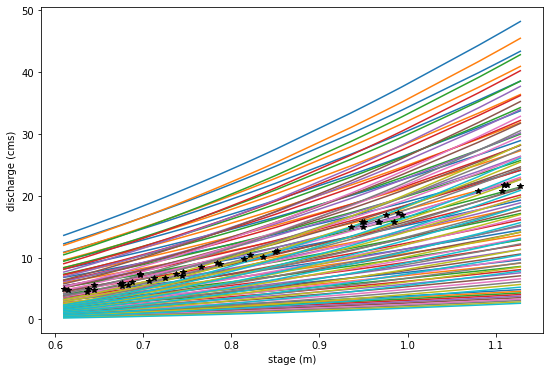

In [22]:
plt.figure(figsize=(9,6))
# Note, because c doesn't matter much, we will just choose a c value from the middle

for ia in range(nx):
    for ib in range(nx):
        plt.plot(h_now,np.reshape(Qest[ia,ib,5,:],h_now.size))

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*')

In [23]:
# Reshape Qfit and Qest for a single c value to only look at variations of a and b
ic = 5
Qfit2 = np.reshape(Qfit[:,:,ic],[10,10])
Qest2 = np.reshape(Qest[:,:,ic,:],[10,10,h_now.size])

# Find the corresponding Qest values for different ranges of RMSE
Qest_rmse1 = Qest2[Qfit2<1]                # RMSE < 1
Qest_rmse3 = Qest2[(Qfit2>=1) & (Qfit2<3)] # 1 <= RMSE < 3
Qest_rmse5 = Qest2[(Qfit2>=3) & (Qfit2<5)] # 3 <= RMSE < 5

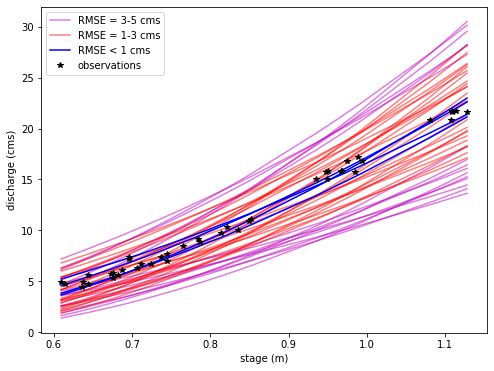

In [24]:
plt.figure(figsize=(8,6))

# Plot the rating curves with RMSE between 3 and 5 cms
for i in range(Qest_rmse5.shape[0]):
    if i ==0:
        label='RMSE = 3-5 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse5[i],'m',alpha=0.5,label=label)
    
# Plot the rating curves with RMSE between 1 and 3 cms
for i in range(Qest_rmse3.shape[0]):
    if i ==0:
        label='RMSE = 1-3 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse3[i],'r',alpha=0.5,label=label)
    
# Finally plot the rating curves with RMSE < 1 cms
for i in range(Qest_rmse1.shape[0]):
    if i ==0:
        label='RMSE < 1 cms'
    else:
        label=None
    plt.plot(h_now, Qest_rmse1[i],'b',alpha=1,label=label)

plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'k*',label='observations')
plt.legend();

### C. Bayesian MCMC fitting

In [25]:
b0 = 0.2833
a0 = 25
c0 = 1.66 # and this one I won't vary

In [26]:
Qest0 = a0 * (h_now-b0)**c0
SSE0 = np.sum((Qest0-Qobs_now)**2)
SSE0

158.11032268871054

In [27]:
# So, I set my limits of my uniform distribution
amin = 5
amax = 50
bmin = 0.15
bmax = 0.45

# for first step, I know I picked values in with the range, so 
P0 = 1

In [28]:
Lmc = 10000 #number of steps to run MCMC routine for.
burn_in = 1000 #estimate the number of steps before Markov Chain becomes stationary
# basically, the burn-in steps will not be used in calculating final probabilities because 
# they depend on the initial parameter estimates.

# Initialize arrays to store results in
PthetaQ = np.ones((Lmc,1))
amc = np.zeros((Lmc,1))
bmc = np.zeros((Lmc,1))

In [29]:
PthetaQ[0] = SSE0*P0 # this is our starting point.
    # Note that this calculation is not a true probability of P(theta|Q) but a relative metric
amc[0] = a0
bmc[0] = b0
# We save all the values at each step.

In [30]:
for imc in range(1,Lmc):
    
        # first we jump in a
    newjumpa = amc[imc-1] + (amax-amin)/(10*np.random.normal())
    
        # Now we repeat with a jump in b, assuming it's totally independent of a
        # and require both to be within their uniform distributions. 
        
    newjumpb = bmc[imc-1] + (bmax-bmin)/(10*np.random.normal())
    
    if (newjumpa >= amin) and (newjumpa <= amax) and (newjumpb >= bmin) and (newjumpb <= bmax):
        #then the prior is okay, and we can proceed 
        # (Note that prior makes any choice outside of our set range impossible)
        Qest1 = newjumpa*(h_now-newjumpb)**c0
        
        # calculate how well the parameters at our new location lead to a model that matches the data
        SSE1=np.sum((Qest1-Qobs_now)**2)
        
        # posterior is SSE1*1 (because we're within the prior uniform domain)
        # the if statement essentially says everything else is multiplied by 0
        
        if SSE1 < PthetaQ[imc-1]:
            # then the error is less, and we found a better place, and we update a and b
            amc[imc] = newjumpa
            bmc[imc] = newjumpb
            PthetaQ[imc] = SSE1 # this becomes the one to beat
        else:
            jumpscore = PthetaQ[imc-1]/SSE1 # this gives a number between 0 and 1
            
            # This is essentially a rating of how much worse this new location is than 
            # where you are right now.  The sum of squared errors is larger, but by how much
            
            # Generate random number from 0 to 1, so that we will jump with a probability of 
            # the jumpscore
            # if our new SSE is 90% as good as our current one, we jump there 90% of the time; 
            # if it's 10% as good, we jump there 10% of the time
            if np.random.uniform() <= jumpscore:
                # then we go there
                amc[imc] = newjumpa
                bmc[imc] = newjumpb
                PthetaQ[imc] = SSE1 # this becomes the one to beat
            else:
                amc[imc]=amc[imc-1]
                bmc[imc]=bmc[imc-1]
                PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are for another timestep

    else:
    # you are outside of the bounds of the uniform prior, so posterior would be 0 and we don't go there
        amc[imc]=amc[imc-1]
        bmc[imc]=bmc[imc-1]
        PthetaQ[imc]=PthetaQ[imc-1] # we stay where we are


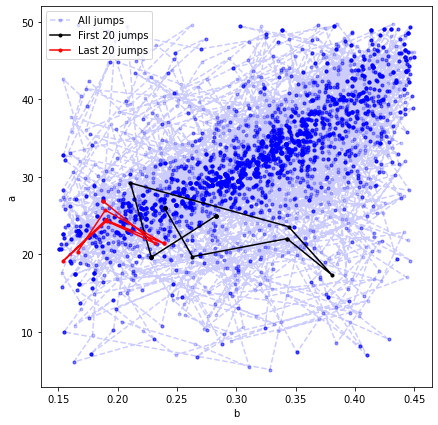

In [31]:
# Visualize all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.plot(bmc,amc,'b.--',alpha=0.2,label='All jumps')
# Visualize the first 20 jumps
plt.plot(bmc[:20],amc[:20],'k.-',alpha=1,label='First 20 jumps')
# Visualize the last 20 jumps
plt.plot(bmc[-20:],amc[-20:],'r.-',alpha=1,label='Last 20 jumps')
plt.xlabel('b')
plt.ylabel('a')
plt.legend();

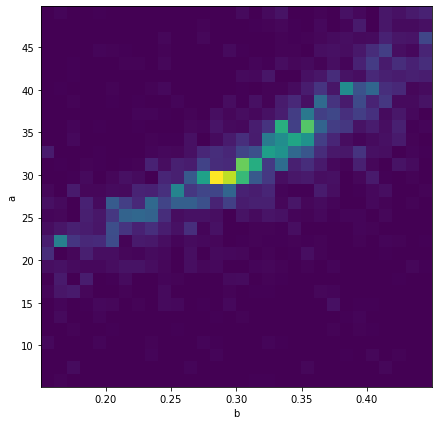

In [32]:
# "Heatmap" of all jumps across the a vs b parameter space
plt.figure(figsize=(7,7))
plt.hist2d(bmc.ravel(),amc.ravel(),30);
plt.xlabel('b')
plt.ylabel('a');

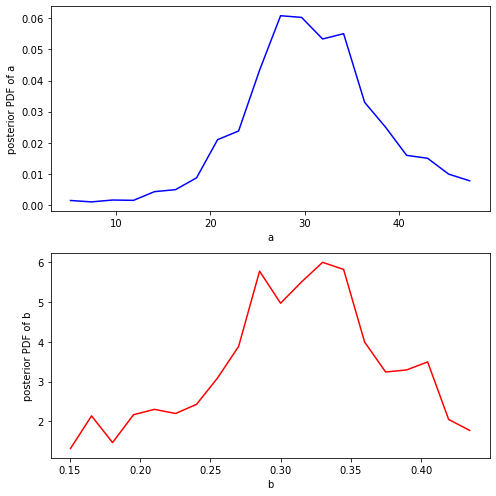

In [33]:
# What are the marginal PDFs for a and b?
a = plt.hist(amc[burn_in:],20);
b = plt.hist(bmc[burn_in:],20);
plt.close();

f, ax = plt.subplots(2,1,figsize=(7,7))
# A
ax[0].plot(a[1][:-1],a[0]/(np.sum(a[0])*(a[1][1]-a[1][0])),'b')
ax[0].set_xlabel('a')
ax[0].set_ylabel('posterior PDF of a')
# B
ax[1].plot(b[1][:-1],b[0]/(np.sum(b[0])*(b[1][1]-b[1][0])),'r')
ax[1].set_xlabel('b')
ax[1].set_ylabel('posterior PDF of b')
f.tight_layout()

In [34]:
# evenly space 25 stage values (could have more if doesn't look smooth)
hh=np.linspace(0.54,1.5,25) 

# Make an empirical CDF for all calculated values of Q using a and b after the burn-in time 
# and plot the median and 95% confidence values from the Markov Chain generated probabilities
NN=amc[burn_in:].size

In [35]:
Q025 = np.ones((hh.shape))
Q50 = np.ones((hh.shape))
Q975 = np.ones((hh.shape))

for ih in range (hh.size):
    Qhh = amc[burn_in:]*(hh[ih]-bmc[burn_in:])**c0
    xsort = np.sort(Qhh[:,0])
    ranks = np.array(range(NN))+1
    x_CDF = 1 - (ranks - 0.4)/(NN + 0.2)
    
    Q025[ih] = np.interp(0.025,1-x_CDF,xsort)
    Q975[ih] = np.interp(0.975,1-x_CDF,xsort)
    Q50[ih] = np.interp(0.5,1-x_CDF,xsort)

Text(0.5, 1.0, 'Best estimate with 95% confidence intervals')

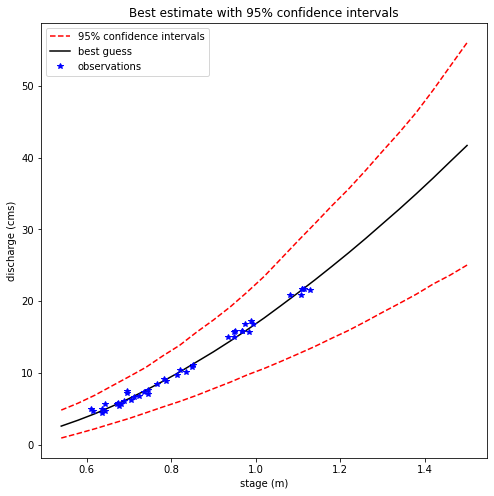

In [36]:
plt.figure(figsize=(8,8))
plt.plot(hh,Q025,'r--',label='95% confidence intervals')

plt.plot(hh,Q975,'r--')
plt.plot(hh,Q50,'k-',label='best guess')
plt.xlabel('stage (m)')
plt.ylabel('discharge (cms)')
plt.plot(h_now,Qobs_now,'b*',label='observations')
plt.legend()
plt.title('Best estimate with 95% confidence intervals')

### D. Comparison of Methods

While all three methods produce results that roughly fit the data, it's important to explore some of the differences between the methods. Bayesian MCMC fitting seems to be the most computationally intensive, but due to the fact that the number of steps can be increased (and jump rules can be changed to be more granular in the parameter space), this method seems to produce the most accurate results though you really should have a strong idea of what you're looking for to inform your goodness of fit rules. The direct monte carlo parameter estimation also loops through a parameter space, but with set widths (step sizes) for each parameter. This means the granularity of our parameter estimation is coarser, and our ideal parameter value is likely between two discrete steps. With more parameters and greater range of parameter values, these brute force approaches will become infeasible. The least squares method required the least amount of computation and prior information, which might be good for problems when there are more unknowns and less understanding of underlying physics and mechanics of a system. The minimization of the squares of the error could be problematic though depending on the physical phenomena you are studying, as it might be more preferable to use a different norm or metric especially if you are concerned with outlier influence. In the end though, all of these methods rely on some sort of formulation of a loss function, therefore it is very important to know what conditions you are trying to optimize for regardless of method. 

## Problem 3: Work on your term projects (CEWA 565)

Ok!

# References

Note: A large amount of this code is adapted from the CEWA 565 course materials, predominantly from the lab 7 jupyter notebook which can be found in module 6 of the class website: https://mountain-hydrology-research-group.github.io/data-analysis/modules/module7.html